<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/main/tim-ft-densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pydicom -q

     |████████████████████████████████| 2.0 MB 36.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output

path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

clear_output(wait=True)
!unzip {path}

In [77]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
import torch
import torchvision
from torch.profiler import profile, record_function, ProfilerActivity

import pydicom as dicom
from PIL import Image

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

In [69]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    if indices:
      self.img_labels = pd.read_csv(annotations_file).iloc[indices]
    else:
      self.img_labels = pd.read_csv(annotations_file)

    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(img_path)
    image = Image.fromarray(image.pixel_array).convert(mode='RGB')

    label = self.img_labels.iloc[idx, -1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

  def get_classes(self):
    return self.img_labels.iloc[:, -1].unique()

  classes = property(get_classes)

In [97]:
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content'

label_df = pd.read_csv(annotations_file)

X_train, X_test = train_test_split(label_df, test_size=.2, stratify=label_df.Target, random_state=99)
X_val, X_test, = train_test_split(X_test, test_size=.5, stratify=X_test.Target, random_state=99)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), (X_test.index.tolist())

len(X_train), len(X_val),  len(X_test)

(24181, 3023, 3023)

In [98]:
mean = [0.5132, 0.5132, 0.5132]
std = [0.2483, 0.2483, 0.2483]

transforms = dict(
  train = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.RandomHorizontalFlip(.5),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ]),
  val = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.CenterCrop(224),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ])
)

datasets = dict(
    train=CustomImageDataset(annotations_file, img_dir, indices=X_train, transform=transforms['train']),
    val=CustomImageDataset(annotations_file, img_dir, indices=X_val, transform=transforms['val']),
    test=CustomImageDataset(annotations_file, img_dir, indices=X_test, transform=transforms['val']),
)

In [100]:
batch_size = 32

data_loaders = dict(
    train=DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
    val=DataLoader(datasets['val'], batch_size=batch_size, shuffle=True),
    test=DataLoader(datasets['test'], batch_size=batch_size),
)

dataset_sizes = {x:len(datasets[x]) for x in ('train', 'val', 'test')}

print('training steps per epoch:', dataset_sizes['train']//batch_size)
print('validation steps per epoch:', dataset_sizes['val']//batch_size)
print('test steps per epoch:', dataset_sizes['test']//batch_size)

training steps per epoch: 755
validation steps per epoch: 94
test steps per epoch: 94


In [10]:
# Uncomment and run to get mean and standard deviation
# for x, y in train_data_loader:
#   break

# x.mean(dim=(0, 2, 3)), x.std(dim=(0, 2, 3))

(tensor([0.5132, 0.5132, 0.5132]), tensor([0.2483, 0.2483, 0.2483]))

In [101]:
def checkpoint(model, best_loss, epoch, LR):
    print('saving')
    state = {
        'model': model,
        'best_loss': best_loss,
        'epoch': epoch,
        'rng_state': torch.get_rng_state(),
        'LR': LR
    }

    torch.save(state, '/content/checkpoint')

model = torchvision.models.densenet121(weights='DEFAULT')
# Freeze all layers for fine-tuning
for params in model.parameters():
  params.requires_grad=False

# add final layer with # outputs in same dimension of labels with sigmoid
# activation
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.classifier.in_features, 2), 
    torch.nn.LogSoftmax(dim=1))

init_learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = torch.nn.NLLLoss()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [90]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_loss = 1e+8

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs-1}')
    print('-' * 10)

    for phase in ('train', 'val'):
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for (inputs, labels) in data_loaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      lr = next(iter(optimizer.param_groups))['lr']

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} LR: {lr:6f}')

      # deep copy the model
      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Loss: {best_acc:4f}')
  print(f'Best val Acc: {best_loss:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [91]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5070 Acc: 0.7483 LR: 0.001000
val Loss: 0.4522 Acc: 0.7790 LR: 0.001000
Epoch 1/9
----------
train Loss: 0.4626 Acc: 0.7728 LR: 0.001000
val Loss: 0.4387 Acc: 0.7907 LR: 0.001000
Epoch 2/9
----------
train Loss: 0.4464 Acc: 0.7887 LR: 0.001000
val Loss: 0.4555 Acc: 0.7742 LR: 0.001000
Epoch 3/9
----------
train Loss: 0.4351 Acc: 0.7905 LR: 0.001000
val Loss: 0.4534 Acc: 0.7750 LR: 0.001000
Epoch 4/9
----------


KeyboardInterrupt: ignored

In [63]:
running_outputs = torch.Tensor().to(device)
running_preds = torch.Tensor(0, 2).to(device)

with torch.no_grad():
  model.eval()
  for i, (inputs, labels) in enumerate(data_loaders['test']):
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    running_preds = torch.vstack((running_preds, preds))
    running_outputs = torch.cat((running_outputs, labels), dim=0)

n true: 4000
n predictions: 4000


precision:	0.7850
recall:		0.6445
f1:		0.7079



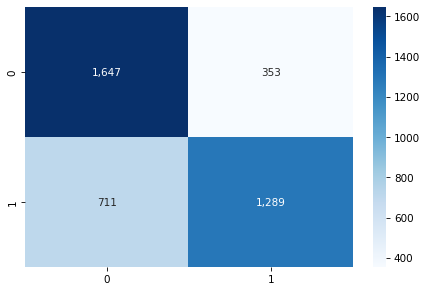

In [65]:
y_true = running_outputs.cpu().numpy()
y_pred = running_preds.cpu().numpy().argmax(axis=1)
y_proba = torch.nn.Softmax(dim=1)(preds).cpu().numpy()[:, 1]

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

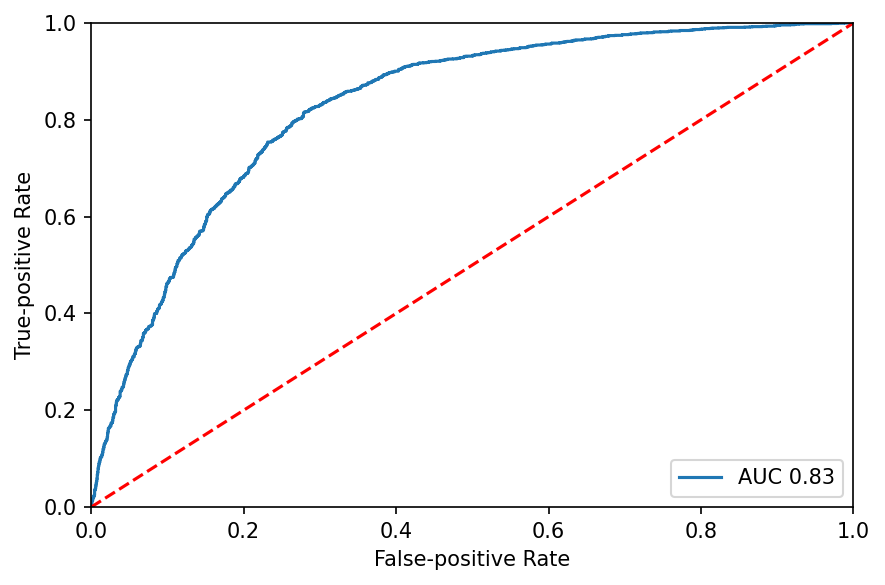

In [66]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

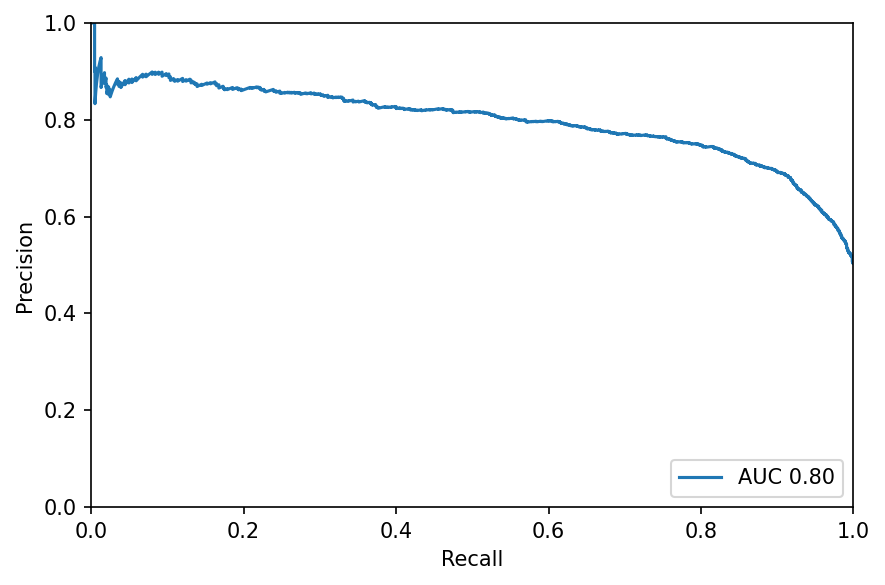

In [67]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()